In [1]:
import sys
sys.executable = '/Applications/anaconda/envs/sherpa411/bin/python'
sys.path = ['', '/Applications/heasoft-6.24/x86_64-apple-darwin17.4.0/lib/python', 
            '/Applications/heasoft-6.24/x86_64-apple-darwin17.4.0/lib', 
            '/Applications/anaconda/envs/sherpa411/lib/python36.zip', 
            '/Applications/anaconda/envs/sherpa411/lib/python3.6', 
            '/Applications/anaconda/envs/sherpa411/lib/python3.6/lib-dynload', 
            '/Applications/anaconda/envs/sherpa411/lib/python3.6/site-packages', 
            '/Applications/anaconda/envs/sherpa411/lib/python3.6/site-packages/sherpa-4.11.0+0.g838bd12b.dirty-py3.6-macosx-10.9-x86_64.egg']

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")
%matplotlib inline

import sherpa.astro.ui as ui
import astropy.modeling.models as models
from astropy.modeling.fitting import _fitter_to_model_params
from sherpa.astro import xspec
import scipy.stats

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [15]:
!pwd

/Users/mlazz/Dropbox/UW/PileupABC/PileupABC/Margaret


In [16]:
def simdat_sherpa_old(obs_time,gamma):
    #Load fake PHA data to get energy bins
    datadir = "/Users/mlazz/Dropbox/UW/PileupABC/PileupABC/Margaret/"
    ui.load_data(id="p1", filename=datadir+"fake_acis.pha")
    d = ui.get_data("p1")
    bin_lo = d.bin_lo
    bin_hi = d.bin_hi
    bin_mid = bin_lo + (bin_hi - bin_lo) / 2.0

    #Extract counts and read in ARF and RMF
    counts = d.counts
    arf = d.get_arf() # get out an ARF object
    rmf = d.get_rmf() # get out an RMF object
    #Get exposure time, and energy bins from ARF
    exposure = arf.exposure # exposure time in seconds
    specresp = arf.specresp # the actual response in the ARF, i.e. effective area + stuff
    energ_lo = arf.energ_lo
    energ_hi = arf.energ_hi
    
    norm = obs_time/1.0e7 # input power law normalization
    PhoIndex = gamma # input power law photon index (is negative by default)

    #Use XSPEC to generate simple power law spectral model with given observation time and photon index
    p = xspec.XSpowerlaw()
    p.norm = norm
    p.PhoIndex = PhoIndex
    base_model = p(energ_lo, energ_hi)
    #Apply ARF and RMF to power law spectrum
    base_arf = arf.apply_arf(base_model)*exposure
    base_spec = rmf.apply_rmf(base_arf)
    
    #Implement pile up:
    np.random.seed(200) # set the seed for reproducibility
    nphot = np.random.poisson(np.sum(base_spec)) #number of photons is Poisson distributed around expected value
    print(nphot,'photons')
    tstart = 0
    tend = tstart + exposure
    phot_times = np.random.uniform(tstart, tend, size=nphot)
    phot_times = np.sort(phot_times)

    spec_pdf = base_spec/np.sum(base_spec)
    phot_energies = np.random.choice(energ_lo, size=nphot, replace=True, p=spec_pdf)

    frametime = 3.2
    intervals = np.arange(tstart, tend+frametime, frametime) #set the times that the detector will be read
    #Apply pileup with binned_statistic which counts up number of photons that arrive within a read time
    summed_erg, bins, bin_idx = scipy.stats.binned_statistic(phot_times, phot_energies, bins=intervals, statistic="sum")
    n_per_bin = np.bincount(bin_idx-1) # bin_idx is one-indexed for reasons I don't understand!
    phot_per_bin, bins2 = np.histogram(phot_times, bins=intervals)
    summed_erg = summed_erg[(summed_erg > 0) & (summed_erg < np.max(energ_hi))]
    energ_intervals = np.hstack([energ_lo, energ_hi[-1]])
    spec_nopileup, spec_bins = np.histogram(phot_energies, bins=energ_intervals)
    spec_pileup, spec_bins = np.histogram(summed_erg, bins=energ_intervals)
    
    pileup_fraction = len(n_per_bin[n_per_bin > 1])/len(n_per_bin)
    print("%i percent of the frames have piled events in them."%(pileup_fraction*100))
    
    return energ_intervals, spec_pileup, spec_nopileup, d
    

In [48]:
#Updated following meeting with Victoria and Daniela
def simdat_sherpa(log_norm,gamma,d):
    #Load fake PHA data to get energy bins
    #datadir = "/Users/mlazz/Dropbox/UW/PileupABC/PileupABC/Margaret/"
    #ui.load_data(id="p1", filename=datadir+"fake_acis.pha")
    #d = ui.get_data("p1")
    #bin_lo = d.bin_lo
    #bin_hi = d.bin_hi
    #bin_mid = bin_lo + (bin_hi - bin_lo) / 2.0

    #Extract counts and read in ARF and RMF
    #counts = d.counts
    arf = d.get_arf() # get out an ARF object
    rmf = d.get_rmf() # get out an RMF object
    #Get exposure time, and energy bins from ARF
    exposure = arf.exposure # exposure time in seconds
    specresp = arf.specresp # the actual response in the ARF, i.e. effective area + stuff
    energ_lo = arf.energ_lo
    energ_hi = arf.energ_hi
    
    #norm = exposure/1.0e7 # input power law normalization
    #PhoIndex = gamma # input power law photon index (is negative by default)

    #Use XSPEC to generate simple power law spectral model with given observation time and photon index
    p = xspec.XSpowerlaw()
    norm = np.power(10,log_norm)
    p.norm = norm
    p.PhoIndex = gamma
    base_model = p(energ_lo, energ_hi)
    #Apply ARF and RMF to power law spectrum
    base_arf = arf.apply_arf(base_model)*exposure
    #base_spec = rmf.apply_rmf(base_arf)
    
    #Implement pile up:
    #np.random.seed(200) # set the seed for reproducibility
    nphot = np.random.poisson(np.sum(base_arf)) #number of photons is Poisson distributed around expected value
    print(nphot,'photons')
    count_rate = nphot/exposure
    tstart = 0
    tend = tstart + exposure
    phot_times = np.random.uniform(tstart, tend, size=nphot)
    phot_times = np.sort(phot_times)

    spec_pdf = base_arf/np.sum(base_arf)
    phot_energies = np.random.choice(energ_lo, size=nphot, replace=True, p=spec_pdf)

    frametime = 3.2 #set by Chandra
    intervals = np.arange(tstart, tend+frametime, frametime) #set the times that the detector will be read
    #Apply pileup with binned_statistic which counts up number of photons that arrive within a read time
    summed_erg, bins, bin_idx = scipy.stats.binned_statistic(phot_times, phot_energies, bins=intervals, statistic="sum")
    n_per_bin = np.bincount(bin_idx-1) # bin_idx is one-indexed for reasons I don't understand!
    #phot_per_bin, bins2 = np.histogram(phot_times, bins=intervals)
    summed_erg = summed_erg[(summed_erg > 0) & (summed_erg < np.max(energ_hi))]
    energ_intervals = np.hstack([energ_lo, energ_hi[-1]])
    #print(energ_intervals)
    nopileup, spec_bins = np.histogram(phot_energies, bins=energ_intervals)
    pileup, spec_bins = np.histogram(summed_erg, bins=energ_intervals)
    spec_nopileup = rmf.apply_rmf(nopileup)
    spec_pileup = rmf.apply_rmf(pileup)
    #spec_nopileup=nopileup
    #spec_pileup=pileup
    pileup_fraction = len(n_per_bin[n_per_bin > 1])/len(n_per_bin)
    print("%i percent of the frames have piled events in them."%(pileup_fraction*100))
    
    return energ_intervals, spec_pileup, spec_nopileup, d
    

In [8]:
def plot_data(energy_bins,piled,not_piled,dd):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.plot(energy_bins[:-1], not_piled, label="no pile-up")
    ax.plot(energy_bins[:-1], piled, label="with pile-up")
    ax.plot(energy_bins[:-1], dd.counts/1000)
    ax.legend()

    ax.set_xlabel("Energy [keV]")
    ax.set_ylabel("Number of photons per bin")
    plt.savefig('sherpa_spectrum.pdf')

In [42]:
datadir = "/Users/mlazz/Dropbox/UW/PileupABC/PileupABC/Margaret/"
ui.load_data(id="p1", filename=datadir+"fake_acis.pha")
d = ui.get_data("p1")

statistical errors were found in file '/Users/mlazz/Dropbox/UW/PileupABC/PileupABC/Margaret/fake_acis.pha' 
but not used; to use them, re-read with use_errors=True
read ARF file arfs/aciss_hetg0_cy19.arf
read RMF file rmfs/aciss_hetg0_cy19.rmf


In [40]:
rmf = d.get_rmf()
print(rmf)

name     = rmfs/aciss_hetg0_cy19.rmf
detchans = 1024
energ_lo = Float64[1024]
energ_hi = Float64[1024]
n_grp    = UInt64[1024]
f_chan   = UInt64[1509]
n_chan   = UInt64[1509]
matrix   = Float64[387112]
offset   = 1
e_min    = Float64[1024]
e_max    = Float64[1024]
ethresh  = 1e-10


/Applications/anaconda/envs/sherpa411/lib/python3.6/site-packages/sherpa-4.11.0+0.g838bd12b.dirty-py3.6-macosx-10.9-x86_64.egg/sherpa/utils/__init__.py:1349: VisibleDeprecationWarning: sctypeNA and typeNA will be removed in v1.18 of numpy
  v = '%s[%d]' % (numpy.typeNA[v.dtype.type], v.size)
/Applications/anaconda/envs/sherpa411/lib/python3.6/site-packages/sherpa-4.11.0+0.g838bd12b.dirty-py3.6-macosx-10.9-x86_64.egg/sherpa/utils/__init__.py:1349: VisibleDeprecationWarning: sctypeNA and typeNA will be removed in v1.18 of numpy
  v = '%s[%d]' % (numpy.typeNA[v.dtype.type], v.size)
/Applications/anaconda/envs/sherpa411/lib/python3.6/site-packages/sherpa-4.11.0+0.g838bd12b.dirty-py3.6-macosx-10.9-x86_64.egg/sherpa/utils/__init__.py:1349: VisibleDeprecationWarning: sctypeNA and typeNA will be removed in v1.18 of numpy
  v = '%s[%d]' % (numpy.typeNA[v.dtype.type], v.size)
/Applications/anaconda/envs/sherpa411/lib/python3.6/site-packages/sherpa-4.11.0+0.g838bd12b.dirty-py3.6-macosx-10.9-x86_6

In [49]:
energ_bins, pileup, no_pileup, dd = simdat_sherpa(-2.3,1.7,d);

4077 photons
38 percent of the frames have piled events in them.


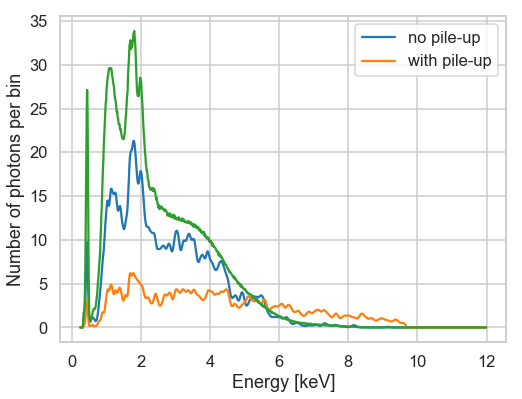

In [50]:
plot_data(energ_bins,pileup,no_pileup,dd)

In [17]:
en_bins, p, nop, ddd = simdat_sherpa_old(50000,1.7)

statistical errors were found in file '/Users/mlazz/Dropbox/UW/PileupABC/PileupABC/Margaret/fake_acis.pha' 
but not used; to use them, re-read with use_errors=True
read ARF file arfs/aciss_hetg0_cy19.arf
read RMF file rmfs/aciss_hetg0_cy19.rmf
4200 photons
38 percent of the frames have piled events in them.


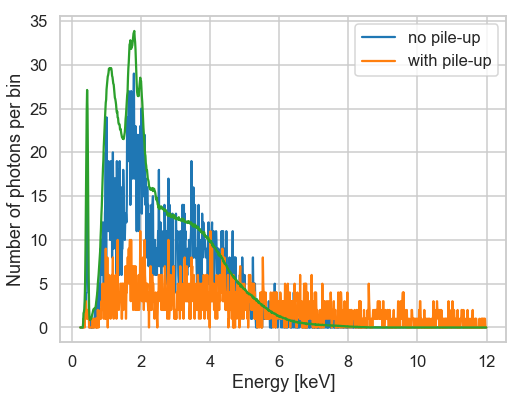

In [18]:
plot_data(en_bins,p,nop,ddd)